# Generate Training Points

Forked from https://github.com/frontiersi/FAO_LC_workshop_Rwanda/blob/main/0_Generate_Training_Points.ipynb and https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb

## Background

**Training data** is the most important part of any supervised machine learning workflow. The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)).  A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034).

There are many platforms to use for gathering land cover training labels, the best one to use depends on your application. GIS platforms are great for collecting training data as they are highly flexible and mature platforms; [Geo-Wiki](https://www.geo-wiki.org/) and [Collect Earth Online](https://collect.earth/home) are two open-source websites that may also be useful depending on the reference data strategy employed. Alternatively, there are many pre-existing training datasets on the web that may be useful, e.g. [Radiant Earth](https://www.radiant.earth/) manages a growing number of reference datasets for use by anyone. With locations of land cover labels available, we can extract features at these locations from satellite imagery as input for machine learning.  

## Description

As timely training data is not always available, in this notebook we demonstrate how to generate a set of randomly distributed training points for a selected district in Rwanda from an existing classification map.

The workflow includes the following steps:

1. Preview the district boundaries of Rwanda on a basemap
2. Select a district as area of analysis
3. Merging classes on the classification map to keep only those you want
4. Generate randomly distributed training points and export for future use

***

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

Note: The approximate running time for the default setting is about 2 minutes.

### Load packages


In [3]:
%matplotlib inline
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch
from random_sampling import random_sampling # adapted from function by Chad Burton: https://gist.github.com/cbur24/04760d645aa123a3b1817b07786e7d9f
from datacube.utils.cog import write_cog

## Analysis parameters

* `input_polygons_path`: The path to the shapefile containing polygons of Rwanda administrative boundaries. Here we use [administrative level 3 boundaries file](https://geoportal.icpac.net/layers/geonode%3Arwa_adm3). 
* `input_map_path`: The classification map used to extract the training points. Here we use the [Rwanda Land Cover 2015 Scheme II map](http://geoportal.rcmrd.org/layers/servir%3Arwanda_landcover_2015_scheme_ii).
* `name_attribute`: This is the name of column in your shapefile attribute table that identifies the name of each polygon at an administrative level.
>**Note**: If you change your file to a different shapefile, remember to update this variable to identify your area of interest.
* `output_crs`: Output spatial reference system.

In [23]:
input_polygons_path = 'singapore_bbox_polygon.geojson'
# input_polygons_path = 'viti_levu_bbox_polygon.geojson'
input_map_path='singapore_worldcover_2020_june_100m.tif'
# name_attribute = 'NAME_3'
output_crs='epsg:32648' # WGS84/UTM Zone 48N for Singapore

## Load and display input data
Let's load the administration polygons:

In [24]:
singapore_polygon=gpd.read_file(input_polygons_path)
singapore_polygon.head()

,geometry
0,"POLYGON ((103.57803 1.48074, 103.57803 1.19263..."


In [37]:
from odc.geo import BoundingBox

bbox = BoundingBox(*(singapore_polygon.total_bounds), crs="EPSG:4326")
bbox.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    # popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )

## Use ESA Worldcover as data.
In future combine this with other LU/LC products to check agreement (use https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb)

In [26]:
from pystac.client import Client
from odc.stac import load
import xarray as xr
from planetary_computer import sign_url
import rioxarray
import pandas as pd
import rasterio
from scipy.ndimage import uniform_filter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys, os
sys.path.append(os.path.abspath(".."))
from src.spatial import list_countries, get_country_boundary
from src.Compare_LULC_func import standardise_class

In [27]:
# Use Planetary Computer STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

# A generic function to load a product given the boundary
def load_lulc_data(product: str, resolution = 100):
    items = catalog.search(
        collections=[product],
        intersects=bbox.polygon, # Singapore bounding box
        datetime="2020-06",
    ).item_collection()

    print(f"Found {len(items)} items for product {product}")

    ds = load(
        items,
        intersects=bbox.polygon, # Singapore bounding box
        crs="EPSG:6933",
        groupby="solar_day",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        patch_url=sign_url,
        resample_alg="nearest",
    )

    print(f"Product {product} has variables: {ds.data_vars}")
    return ds

In [ ]:
# cci_da = load_lulc_data('esa-cci-lc', resolution=300)

# vars = list(cci_da.data_vars)
# cci_da["esa_cci_lc"] = cci_da["lccs_class"]
# ds_tmp = cci_da.drop_vars(vars)
# cci_da = ds_tmp.squeeze().load() # removes any singleton dimension and then load the full data

# # Limit the product within the administrative boundary (mainly for removing the water body)
# region_gdf = gdf.to_crs(epsg=6933)
# data = cci_da.rio.write_crs("EPSG:6933")
# geom = region_gdf.geometry.values
# cci_da = data.rio.clip(geom, region_gdf.crs)

In [28]:
wc_da = load_lulc_data('esa-worldcover', resolution=100) # resolution=10

vars = list(wc_da.data_vars)
wc_da["esa_worldcover"] = wc_da["map"]
ds_tmp = wc_da.drop_vars(vars)
wc_da = ds_tmp.squeeze().load() #removes any singleton dimension and then load the full data

wc_da

# # Reproject WorldCover to match CCI resolution using majority vote
# wc_300m = wc_da.rio.reproject_match(
#     cci_da,
#     resampling=rasterio.enums.Resampling.mode   # majority vote (the value that appears most often)
# )

# Limit the product within the administrative boundary (mainly for removing the water body)
# singapore_polygon_6933 = singapore_polygon.to_crs(epsg=6933)
# data = wc_da.rio.write_crs("EPSG:6933")
# geom = singapore_polygon_6933.geometry.values
# wc_300m = data.rio.clip(geom, singapore_polygon_6933.crs)

Found 1 items for product esa-worldcover
Product esa-worldcover has variables: Data variables:
    map              (time, y, x) uint8 178kB dask.array<chunksize=(1, 368, 485), meta=np.ndarray>
    input_quality.1  (time, y, x) int16 357kB dask.array<chunksize=(1, 368, 485), meta=np.ndarray>
    input_quality.2  (time, y, x) int16 357kB dask.array<chunksize=(1, 368, 485), meta=np.ndarray>
    input_quality.3  (time, y, x) int16 357kB dask.array<chunksize=(1, 368, 485), meta=np.ndarray>


<xarray.Dataset> Size: 185kB
Dimensions:         (y: 368, x: 485)
Coordinates:
  * y               (y) float64 3kB 1.888e+05 1.888e+05 ... 1.522e+05 1.522e+05
  * x               (x) float64 4kB 9.994e+06 9.994e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 178kB 50 10 10 10 60 10 ... 80 80 80 80 80 80

In [29]:
# Define mapping dictionaries for each product
cci_lc_map = {
    10:3, 11:3, 12:3, 20:3, 30:3, #Cropland class -> Cropland
    40:2, 120:2, 121:2, 122:2,#Natural Vegetation -> Grassland, #Shrub class -> Grassland
    50:1, 60:1, 61:1, 62:1, 70:1, 71:1, 72:1, 80:1, 81:1, 82:1, 90:1, 100:1, #Tree class -> Tree, #Tree and shrub - > 1 Tree
    110:2, 130:2, 140:2, #Grass and Herbaceous -> Grassland, #Moss/lichen -> Grassland
    150:2, 151:2, 152:2, 153:2, #Sparse vegetation -> Grassland
    160:4, 170:4,180:4, #Wetland
    190:5, #Build up
    200:6, 201:6, 202:6, 220:6, #Bare class -> other land, #Snow/Ice -> other land
    210:7, #Water
}

world_cover_map = {
    80:7, #Water
    10:1, #Tree
    20:2, 30:2,#Shrub, Grassland -> Grassland
    40:3, #cropland
    50:5, #build up
    60:6, 70:6,#Bare, Snow/Ice -> other land
    90:4, 95:4,#Wetland, Mangroves -> Wetland
    100:6 #Moss/Lichen -> otherland
}

io_map = {
    0:0, #No data
    1:7, #Water
    2:1, #Tree
    4:4, #Wetland
    5:3, #Cropland
    7:5, #Build-up
    8:6, 9:6, 10:6,#Bare/Sparse, #Snow/Ice, #Cloud -> other land
    11:2 #Rangeland
}

In [30]:
# cci_da['esa_cci_lc'] = standardise_class(cci_da['esa_cci_lc'], cci_lc_map)
# wc_300m['esa_worldcover'] = standardise_class(wc_300m['esa_worldcover'], world_cover_map)
# io_300m['io_lulc'] = standardise_class(io_300m['io_lulc'], io_map)
wc_da['esa_worldcover'] = standardise_class(wc_da['esa_worldcover'], world_cover_map)
wc_da


/Users/wj/Library/Caches/pypoetry/virtualenvs/ldn-TK5rT0MB-py3.12/lib/python3.12/site-packages/numpy/_core/numeric.py:475: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset> Size: 185kB
Dimensions:         (y: 368, x: 485)
Coordinates:
  * y               (y) float64 3kB 1.888e+05 1.888e+05 ... 1.522e+05 1.522e+05
  * x               (x) float64 4kB 9.994e+06 9.994e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 178kB 5 1 1 1 6 1 1 1 2 5 ... 7 7 7 7 7 7 7 7 7

In [31]:

# Write as tiff.
wc_da.rio.to_raster(input_map_path, dtype='uint8', compress='deflate')

Let's load the classification map and display it:

In [32]:
# TODO: Make this the merge of agreeing LU/LC products
classification_map=xr.open_dataset(input_map_path,engine="rasterio").astype(np.uint8)
classification_map=classification_map.to_array().squeeze()

>**Note**: If you change the classification map, you will need to understand what class each pixel value represents.

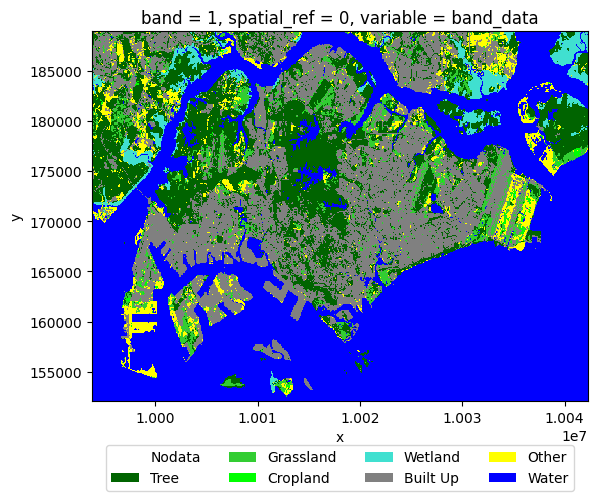

In [36]:
dict_map={'Nodata':0,'Tree':1,'Grassland':2,'Cropland':3,'Wetland':4,
          'Built Up':5,'Other':6,'Water':7}

world_cover_map = {
    10:1, #Tree
    20:2, 30:2,#Shrub, Grassland -> Grassland
    40:3, #cropland
    50:5, #build up
    60:6, 70:6,#Bare, Snow/Ice -> other land
    90:4, 95:4,#Wetland, Mangroves -> Wetland
    100:6 #Moss/Lichen -> otherland
}
# display colour for each class value
colours = {0:'white',1:'darkgreen',2:'limegreen',3:'lime',4:'turquoise',5:'gray',6:'yellow',7:'blue'}

fig, axes = plt.subplots(1,1)

# Plot classification map
unique_values=np.unique(classification_map)
cmap=ListedColormap([colours[k] for k in unique_values])
norm = BoundaryNorm(list(unique_values)+[np.max(unique_values)+1], cmap.N)
classification_map.plot.imshow(ax=axes, 
                   cmap=cmap,
                   norm=norm,
                   add_labels=True, 
                   add_colorbar=False,
                   interpolation='none')
# add colour legend
patches_list=[Patch(facecolor=colour) for colour in colours.values()]
axes.legend(patches_list, list(dict_map.keys()),loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))

TODO: I am up to here. Next up:
1. Generate random points
2. Load geomad for this area
3. Put observational data onto random points.

## Generate random training samples
We generate some randomly distributed samples for each class from the clipped classification map using the `random_sampling` function. This function takes in a few parameters:  
* `da`: a classified map in the format of 2-dimensional xarray.DataArray
* `n`: total number of points to sample.
* `min_sample_n`: Minimum number of samples to generate per class if proportional number is smaller than this. **Note that the resultant number of samples may be higher than the set `n` due to setting of this minimum number of samples.** 
* `sampling`: the sampling strategy, e.g. 'stratified_random' where each class has a number of points proportional to its relative area, 'equal_stratified_random' where each class has the same number of points, or 'manual' which allows you to define number of samples for each class.
* `out_fname`: a filepath name for the function to export a shapefile/geojson of the sampling points into a file. You can set this to `None` if you don't need to output the file.
* `class_attr`: This is the column name of output dataframe that contains the integer class values on the classified map. 
* `drop_value`: pixel value on the classification map to be excluded from sampling.  

The output of the function is a geopandas dataframe of randomly distributed points containing a column `class_attr` identifying class values. 

Here we extract around 50 training points in total and export the points in a geojson file for use in the rest of workflow. Here we use the stratified sampling method by setting 'equal_stratified_random', but also set the minimum number of samples as 3 to avoid missing samples for some minor classes. 

As mentioned earlier we don't want the abandoned classes to be included in the samples we set drop_value as 0 before implementing the function:

We now implement the function and set the output file name incorporating the district name:

In [41]:
# Reproject to WGS84 so sample points are in lat/lon
classification_map_4326 = classification_map.rio.reproject("EPSG:4326")

In [45]:
class_attr='LC_Class_I'
out_fname='training_samples.geojson'
n=1000
min_sample_n=3
gpd_random_samples=random_sampling(da=classification_map_4326,n=n,sampling='stratified_random',
                                   min_sample_n=min_sample_n,out_fname=out_fname,class_attr=class_attr,drop_value=0)

Class 7: sampling at 467locations
Class 5: sampling at 228locations
Class 1: sampling at 186locations
Class 2: sampling at 46locations
Class 6: sampling at 43locations
Class 4: sampling at 26locations
Class 3: sampling at 4locations


/Users/wj/Library/Caches/pypoetry/virtualenvs/ldn-TK5rT0MB-py3.12/lib/python3.12/site-packages/pyogrio/geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [64]:
gpd_random_samples.to_crs("EPSG:4326", inplace=True)
gpd_random_samples.head()

,variable,band,spatial_ref,LC_Class_I,geometry
0,band_data,1,0,7,POINT (103.89967 1.27191)
1,band_data,1,0,7,POINT (103.62264 1.20242)
2,band_data,1,0,7,POINT (103.94061 1.24906)
3,band_data,1,0,7,POINT (103.71118 1.22812)
4,band_data,1,0,7,POINT (103.89872 1.2405)


## Visualise the training data by class

In [81]:
gpd_random_samples["LC_Class_I"] = gpd_random_samples["LC_Class_I"].astype(int)

gpd_random_samples.explore(
    column="LC_Class_I",
    categorical=True,
    categories=(present_classes := sorted(gpd_random_samples["LC_Class_I"].unique())),
    cmap=[colours[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)